### Bayesian Marketing Mix Modeling in Python via PyMC3

https://towardsdatascience.com/bayesian-marketing-mix-modeling-in-python-via-pymc3-7b2071f6001a

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
import pandas as pd
data = pd.read_csv(
    'https://raw.githubusercontent.com/Garve/datasets/4576d323bf2b66c906d5130d686245ad205505cf/mmm.csv',
    parse_dates=['Date'],
    index_col='Date'
)
data

,TV,Radio,Banners,Sales
Date,,,,
2018-01-07,13528.10,0.00,0.00,9779.80
2018-01-14,0.00,5349.65,2218.93,13245.19
2018-01-21,0.00,4235.86,2046.96,12022.66
2018-01-28,0.00,3562.21,0.00,8846.95
2018-02-04,0.00,0.00,2187.29,9797.07
...,...,...,...,...
2021-10-03,0.00,0.00,1691.68,9030.17
2021-10-10,11543.58,4615.35,2518.88,15904.11
2021-10-17,0.00,4556.16,1919.19,12839.29


<AxesSubplot:>

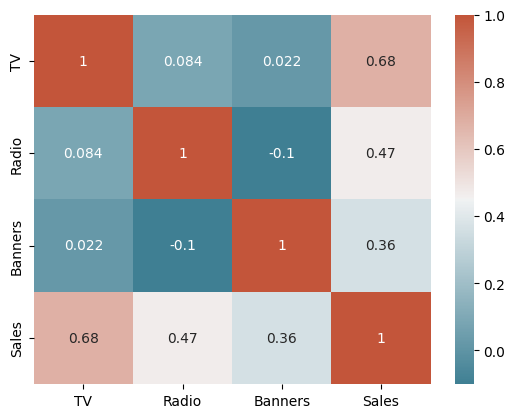

In [3]:
corr = data.corr()
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True, cmap = sns.diverging_palette(220, 20, as_cmap=True))

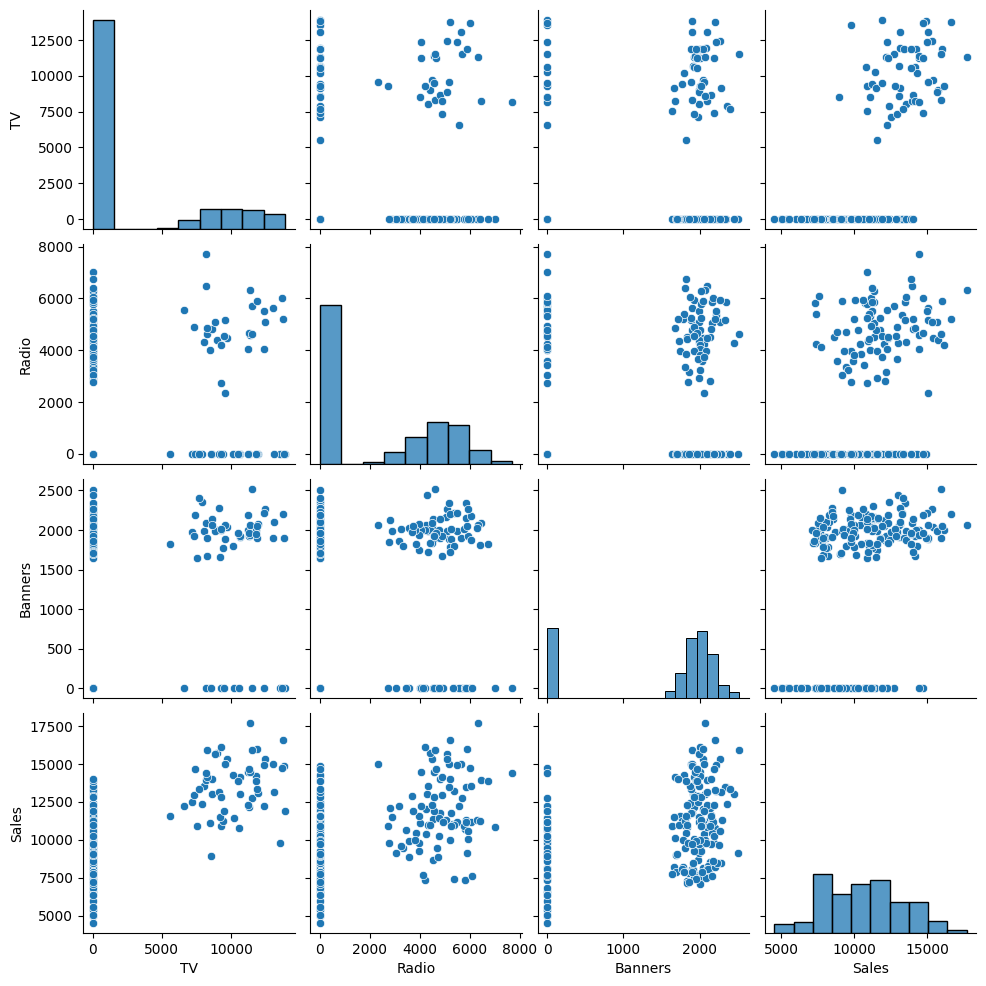

In [4]:
sns.pairplot(data)

In [5]:
X = data.drop(columns=['Sales'])
y = data['Sales']

In [6]:
import theano.tensor as tt
def saturate(x, a):
    return 1 - tt.exp(-a*x)
def carryover(x, strength, length=21):
    w = tt.as_tensor_variable(
        [tt.power(strength, i) for i in range(length)]
    )
    
    x_lags = tt.stack(
        [tt.concatenate([
            tt.zeros(i),
            x[:x.shape[0]-i]
        ]) for i in range(length)]
    )
    
    return tt.dot(w, x_lags)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [ ]:
import pymc3 as pm
with pm.Model() as mmm:
    channel_contributions = []
    
    for channel in X.columns:
        coef = pm.Exponential(f'coef_{channel}', lam=0.0001)
        sat = pm.Exponential(f'sat_{channel}', lam=1)
        car = pm.Beta(f'car_{channel}', alpha=2, beta=2)
        
        channel_data = X[channel].values
        channel_contribution = pm.Deterministic(
            f'contribution_{channel}',
            coef * saturate(
                carryover(
                    channel_data,
                    car
                ),
                sat
            )
        )
        
        channel_contributions.append(channel_contribution)
        
    base = pm.Exponential('base', lam=0.0001)
    noise = pm.Exponential('noise', lam=0.0001)
    
    sales = pm.Normal(
        'sales',
        mu=sum(channel_contributions) + base,
        sigma=noise,
        observed=y
    )
    
    trace = pm.sample(return_inferencedata=True, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\users\ma_ro\appdata\local\programs\python\python38\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, base, car_Banners, sat_Banners, coef_Banners, car_Radio, sat_Radio, coef_Radio, car_TV, sat_TV, coef_TV]


In [ ]:
import statsmodels.formula.api as sm
model = sm.ols(formula="Sales~Banners+Radio+TV", data=data).fit()
print(model.summary())